# Opening images in Keras
Todo:
 - Change from Pillow to rasterio to read image
 - 

Sources:
    - https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a
    - https://stackoverflow.com/questions/46493419/use-a-generator-for-keras-model-fit-generator
    - https://stackoverflow.com/questions/50195967/how-can-i-create-a-4d-numpy-array-from-images
    - https://www.google.com/search?client=firefox-b-ab&q=keras+make+image+generator
 

In [7]:
from PIL import Image

import keras
from PIL import Image

import imageio
import random
import scipy
import numpy as np

import rasterio
import numpy as np


## Variables

In [224]:
image_dir_path = '../Sorted_tiles/'       # Path to images

## Read imagelabels

In [50]:
import pandas as pd
labelfile = pd.read_csv('../Qgis/labeled_tiles.csv')
labelfile.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0,all_bands_merged_01_31.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,all_bands_merged_01_32.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,all_bands_merged_01_33.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,all_bands_merged_01_34.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,all_bands_merged_01_35.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1


In [11]:
labelfile.describe()

,ID,LIVSM1,LIVSM2,1,2,3,4,5,6,7,8,9,10,11,12,99
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.0,551.0,551.0,551.0,551.0,551.0,551.0,551.000000
mean,275.000000,92.520871,92.459165,0.025408,0.021779,0.016334,0.014519,0.019964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.932849
std,159.204271,24.174724,24.405321,0.157505,0.146092,0.126871,0.119726,0.140003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250510
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,137.500000,99.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
50%,275.000000,99.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
75%,412.500000,99.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
max,550.000000,99.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


### Balance classes

In [335]:
# Stratified sample of the classes to get a balanced dataset with the same number of classes to train on.
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
# https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas

# Maximum number of elements in each class. If the classe have less than max every sample is included.
clasnumber_of_samples = 15

labelfile_balanced = labelfile.groupby(['LIVSM1'], group_keys=False).apply(lambda x: x.sample(min(len(x), clasnumber_of_samples))).reset_index(drop=True)
labelfile_balanced.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,275,all_bands_merged_12_27.tif,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0
1,348,all_bands_merged_14_29.tif,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0
2,312,all_bands_merged_13_29.tif,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0
3,311,all_bands_merged_13_28.tif,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0
4,385,all_bands_merged_15_28.tif,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0


In [337]:
# Size of classes
labelfile_balanced_counted = labelfile_balanced.groupby('mult_bin_labels')['ID'].nunique()
labelfile_balanced_counted

mult_bin_labels
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]    15
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]     3
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]     8
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     3
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     9
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    14
Name: ID, dtype: int64

## Homemade image data generator

In [222]:
def flip_vertical(image):
    return np.flipud(image)

def flip_horizontal(image):
    return np.fliplr(image)


def rotate_n_deg(image):
    # Rotates the image a random amount. Fills the space with a reflection of the image. Kva blir best her? Heller bruke rot90?
    rot = random.randrange(-180,180,30)
    rot_image = scipy.ndimage.interpolation.rotate(image, rot,axes=(1, 0), reshape=False, output=None, order=3, mode='reflect', cval=0.0, prefilter=True)

    return rot_image

#def rotate_180(image):
#    return np.rot90(image, k=2)

def random_image_flip_rotation(image):
    # This function rotates or flips the image randomly using one of five functions. 
    # This function can also do nothing to the image. 1/4 chanche.
    # Returns a image

    randint = np.random.randint(low=1, high=4)
    modified_image = 0
    
    if randint == 1:
        modified_image = flip_vertical(image)
    elif randint == 2:
        modified_image = flip_horizontal(image)

    elif randint == 3:
        modified_image = rotate_n_deg(image)

    else:
        modified_image = image
        
    return modified_image

A = np.array([[1, 2, 3], [4, 5, 6], [7,8,9]])
print(A)
print(flip_vertical(A))
print(flip_horizontal(A))
print(rotate_n_deg(A))
print(random_image_flip_rotation(A))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[7 8 9]
 [4 5 6]
 [1 2 3]]
[[3 2 1]
 [6 5 4]
 [9 8 7]]
[[3 6 9]
 [2 5 8]
 [1 4 7]]
[[3 2 1]
 [6 5 4]
 [9 8 7]]


In [223]:
def get_input(path):
    
    img = imageio.imread(path)
    
    return(img)


def image_generator(image_path, label_file):
    # image_path: string where the images are placed.
    # label_file: csv file with labels and filenames.
    
    while True:
        batch_input = []
        batch_x = 0
        
        # Samples the file for a image, removes index so it can be used as loc[0]
        label_sample = label_file.sample().reset_index(drop=True)
        
        # Creates the file paths for the image
        image_sample_path = image_path + label_sample['Tile_name'].item()

        # Reads in each image as array, performs argumentation on each image
        input_raw = get_input(image_sample_path)
        input_permutated = random_image_flip_rotation(input_raw)
        
        # Add a new dimention to the array because Keras wants it this way?
        input_new_dim = np.expand_dims(input_permutated, axis=0)

        
        # Set a label by using the tile name. This line first finds the rowdata for 
        # a spesific tile and gives it out as a dataframe. Then the .iloc function 
        # finds the values of the colums 1 up to 99 and give them out as a list(list in a list). 
        label = label_sample.loc[0, ['1','2','3','4','5','6','7','8','9','10','11','12','99']].values
        
        # Place the labels inside a list in a list because Keras wants it this way??
        label = [[label]]

        yield(input_new_dim, label)

In [225]:
test_generated_images = image_generator(image_dir_path, labelfile_balanced)
generert = next(test_generated_images)
print(generert)
#print(next(test_generated_images))
print(np.shape(generert[0]))
print(generert[1])

(array([[[[7.1224053e-03, 7.1714274e-03, 6.6521158e-03, ...,
          0.0000000e+00, 0.0000000e+00, 1.3110821e-05],
         [6.9298497e-03, 8.0190385e-03, 7.2218417e-03, ...,
          0.0000000e+00, 0.0000000e+00, 1.3110821e-05],
         [8.1814639e-03, 7.6799942e-03, 8.5512009e-03, ...,
          7.6169010e-05, 3.9785362e-05, 0.0000000e+00],
         ...,
         [8.7966174e-03, 8.3507290e-03, 7.6553286e-03, ...,
          8.6783228e-05, 2.5322552e-05, 0.0000000e+00],
         [6.0452609e-03, 5.8857575e-03, 6.8950043e-03, ...,
          8.6783228e-05, 2.5322552e-05, 0.0000000e+00],
         [7.0037325e-03, 7.3904414e-03, 9.0437979e-03, ...,
          9.2565519e-05, 2.2261811e-04, 8.9161571e-05]],

        [[7.6876492e-03, 8.4293084e-03, 8.6015975e-03, ...,
          0.0000000e+00, 0.0000000e+00, 8.3537408e-05],
         [5.7936814e-03, 8.2197022e-03, 7.6892558e-03, ...,
          0.0000000e+00, 0.0000000e+00, 8.3537408e-05],
         [7.5824517e-03, 6.8531325e-03, 7.1922000e-03, 

## Keras model

In [387]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 474)))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy",
                        "sparse_categorical_accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 48, 48, 64)        273088    
_________________________________________________________________
global_average_pooling2d_25  (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 13)                3341      
Total params: 293,069
Trainable params: 293,069
Non-trainable params: 0
_________________________________________________________________


In [402]:
model.fit_generator(
        image_generator(image_dir_path, labelfile_balanced),
        steps_per_epoch=50,
        epochs=10)

Epoch 1/10
50/50 [==============================] - 11s 223ms/step - loss: 0.2360 - categorical_accuracy: 0.3800 - sparse_categorical_accuracy: 0.2431
Epoch 2/10
50/50 [==============================] - 9s 177ms/step - loss: 0.2120 - categorical_accuracy: 0.4600 - sparse_categorical_accuracy: 0.1615
Epoch 3/10
50/50 [==============================] - 10s 197ms/step - loss: 0.2146 - categorical_accuracy: 0.3000 - sparse_categorical_accuracy: 0.2908
Epoch 4/10
50/50 [==============================] - 10s 193ms/step - loss: 0.1855 - categorical_accuracy: 0.4600 - sparse_categorical_accuracy: 0.2308
Epoch 5/10
50/50 [==============================] - 11s 226ms/step - loss: 0.1849 - categorical_accuracy: 0.4000 - sparse_categorical_accuracy: 0.2615
Epoch 6/10
50/50 [==============================] - 14s 280ms/step - loss: 0.1789 - categorical_accuracy: 0.4600 - sparse_categorical_accuracy: 0.1123
Epoch 7/10
50/50 [==============================] - 11s 229ms/step - loss: 0.1650 - categorical

In [475]:
test_image_predict = labelfile_balanced.sample()
test_image_predict.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
28,336,all_bands_merged_14_17.tif,5,4,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,0,1,1,0,0,0,0,0,0,0,0


In [411]:
nn = model.predict_generator(
        image_generator(image_dir_path, test_image_predict),
        steps=1)
print(np.round(nn,2))

[[0.3  0.17 0.2  0.19 0.2  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.64]]


In [405]:
sum(nn[0])

1.4281893414008664

## Save model

In [413]:
model.save('../Models/simple_model0502.h5')

## Create points with predictions as attributes

In [462]:
predicted_classes_gdf = labelfile.copy()
predicted_classes_gdf.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0,all_bands_merged_01_31.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,all_bands_merged_01_32.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,all_bands_merged_01_33.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,all_bands_merged_01_34.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,all_bands_merged_01_35.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1


In [559]:
predicted_classes_gdf = geopandas.GeoDataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'])
predicted_classes_gdf

,1,2,3,4,5,6,7,8,9,10,11,12,99


In [557]:
pp = pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'], data=pred_label)
pp

,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0.018094,0.112057,0.096111,0.001124,0.003376,0.000001,0.000001,0.000003,0.000002,0.000004,0.000002,0.000003,0.672311


In [603]:
stored_labels = []

for num_tile, tile in labelfile.iterrows():
    # Convert pandas.series to pandas.dataframe so it works in image_generator. .T = transpose
    tile_dataframe = tile.to_frame().T 
    
    # Predict the labels of the tile
    pred_label = model.predict_generator(image_generator(image_dir_path, tile_dataframe), steps=1)
    # Store the label in a dataframe
    pred_label_dataframe = pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'], data=pred_label)
    
    # Save all labels in a dataframe
    predicted_classes_gdf = predicted_classes_gdf.append(pred_label_dataframe)
    



In [611]:
predicted_classes_gdf.reset_index(inplace=True, drop=True)
predicted_classes_gdf.head()

,index,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0,0.031604,0.197651,0.230930,0.005412,0.009426,9.953839e-05,1.043657e-04,1.830239e-04,1.773801e-04,2.003248e-04,1.242325e-04,2.405959e-04,0.811695
1,0,0.007376,0.442628,0.314003,0.000486,0.001561,1.944956e-06,2.205384e-06,5.784478e-06,5.122085e-06,7.488272e-06,3.143958e-06,7.271026e-06,0.642822
2,0,0.003680,0.154489,0.159895,0.000172,0.000498,2.400956e-07,2.763997e-07,7.134686e-07,6.700353e-07,8.928739e-07,3.620325e-07,1.088621e-06,0.873682
3,0,0.003104,0.152401,0.158226,0.000136,0.000404,1.656455e-07,1.900670e-07,5.131571e-07,4.785126e-07,6.328684e-07,2.535666e-07,7.828099e-07,0.880668
4,0,0.018697,0.161710,0.198533,0.002462,0.004571,2.490742e-05,2.652191e-05,5.053009e-05,4.854916e-05,5.527899e-05,3.195060e-05,7.014234e-05,0.852817


In [614]:
image_dir_path = '../Sorted_tiles/' 

gdf = geopandas.GeoDataFrame()

for num_tile, tile in labelfile.iterrows():
    
    # Find image path
    tile_path = image_dir_path + tile['Tile_name']
    
    # Open image and find image bounds
    tile_opened = rasterio.open(tile_path)
    tile_bounds = tile_opened.bounds
    
    # Create and store geometry
    tile_bounds_geometry = geopandas.base.box(tile_bounds[0], tile_bounds[1], tile_bounds[2], tile_bounds[3])
    gdf = gdf.append([tile_bounds_geometry])

# Rename geometry colum and create a new index
gdf.columns = ['geometry']
gdf.reset_index(inplace=True, drop=True)

In [615]:
gdf.head()

,geometry
0,"POLYGON ((587171.55 6757675.55, 587171.55 6757..."
1,"POLYGON ((587186.55 6757675.55, 587186.55 6757..."
2,"POLYGON ((587201.55 6757675.55, 587201.55 6757..."
3,"POLYGON ((587216.55 6757675.55, 587216.55 6757..."
4,"POLYGON ((587231.55 6757675.55, 587231.55 6757..."


In [629]:
#predicted_classes_gdf
#result = pd.concat([predicted_classes_gdf, gdf], sort=False)
#result = geopandas.GeoDataFrame( pd.concat( [predicted_classes_gdf, gdf], ignore_index=True,sort=False) )
result = gdf.merge(predicted_classes_gdf, right_index=True, left_index=True)
result

,geometry,index,1,2,3,4,5,6,7,8,9,10,11,12,99
0,"POLYGON ((587171.55 6757675.55, 587171.55 6757...",0,0.031604,0.197651,0.230930,5.411874e-03,0.009426,9.953839e-05,1.043657e-04,1.830239e-04,1.773801e-04,2.003248e-04,1.242325e-04,2.405959e-04,0.811695
1,"POLYGON ((587186.55 6757675.55, 587186.55 6757...",0,0.007376,0.442628,0.314003,4.863516e-04,0.001561,1.944956e-06,2.205384e-06,5.784478e-06,5.122085e-06,7.488272e-06,3.143958e-06,7.271026e-06,0.642822
2,"POLYGON ((587201.55 6757675.55, 587201.55 6757...",0,0.003680,0.154489,0.159895,1.717241e-04,0.000498,2.400956e-07,2.763997e-07,7.134686e-07,6.700353e-07,8.928739e-07,3.620325e-07,1.088621e-06,0.873682
3,"POLYGON ((587216.55 6757675.55, 587216.55 6757...",0,0.003104,0.152401,0.158226,1.358716e-04,0.000404,1.656455e-07,1.900670e-07,5.131571e-07,4.785126e-07,6.328684e-07,2.535666e-07,7.828099e-07,0.880668
4,"POLYGON ((587231.55 6757675.55, 587231.55 6757...",0,0.018697,0.161710,0.198533,2.461610e-03,0.004571,2.490742e-05,2.652191e-05,5.053009e-05,4.854916e-05,5.527899e-05,3.195060e-05,7.014234e-05,0.852817
5,"POLYGON ((587246.55 6757675.55, 587246.55 6757...",0,0.303751,0.167844,0.198066,1.891169e-01,0.206156,2.155703e-02,2.180462e-02,2.243857e-02,2.123691e-02,2.438509e-02,2.282283e-02,2.520058e-02,0.634296
6,"POLYGON ((587141.55 6757660.55, 587141.55 6757...",0,0.080188,0.180622,0.225216,2.296477e-02,0.032842,9.358436e-04,9.722062e-04,1.376531e-03,1.312518e-03,1.447239e-03,1.074419e-03,1.700224e-03,0.770779
7,"POLYGON ((587156.55 6757660.55, 587156.55 6757...",0,0.007855,0.212078,0.187398,4.874056e-04,0.001425,1.195110e-06,1.357828e-06,3.240536e-06,2.906736e-06,4.059891e-06,1.816396e-06,4.317997e-06,0.780497
8,"POLYGON ((587171.55 6757660.55, 587171.55 6757...",0,0.031615,0.197486,0.230882,5.412347e-03,0.009425,9.968239e-05,1.045115e-04,1.831808e-04,1.776099e-04,2.004763e-04,1.243417e-04,2.409508e-04,0.811892
9,"POLYGON ((587186.55 6757660.55, 587186.55 6757...",0,0.031548,0.197551,0.230877,5.397321e-03,0.009402,9.906568e-05,1.038787e-04,1.822237e-04,1.766102e-04,1.994545e-04,1.236587e-04,2.395502e-04,0.811871


In [641]:
gdf_test = geopandas.GeoDataFrame(result, geometry='geometry')
gdf_test.crs = {'init' :'epsg:32632'}
type(gdf_test)

geopandas.geodataframe.GeoDataFrame

In [642]:
gdf_test.to_file('../Models/predictions_model0402.shp', driver='ESRI Shapefile')

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [ ]:
create dataframe

for element in list:
    predict tile labels
    store in dataframe
        
    get tile bounds
    convert tilebounds to polygon
    store in dataframe
    
save as shp with correct epsg

In [431]:
import rasterio
sus = '../Sorted_tiles/' + test_image_predict['Tile_name'].item()
raster = rasterio.open(sus)
suli = raster.bounds
uli = raster.xy(25,25)

print(suli)
print(uli)

BoundingBox(left=587336.55, bottom=6757630.55, right=587351.55, top=6757645.55)
(587344.2000000001, 6757637.899999999)


In [460]:
b = geopandas.base.box(suli[0], suli[1], suli[2], suli[3])
#b = geopandas.base.box(suli[0], suli[2], suli[1], suli[3])

d = {'col1': [1], 'col2': [3]}
ddf = pd.DataFrame(data=d)

gdf = geopandas.GeoDataFrame(ddf, geometry=[b])
gdf.head()

,col1,col2,geometry
0,1,3,"POLYGON ((587351.55 6757630.55, 587351.55 6757..."


<Figure size 432x288 with 0 Axes>

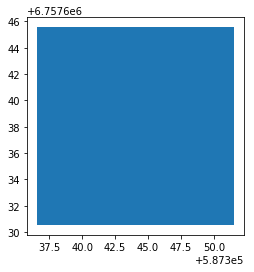

In [453]:
import matplotlib.pyplot as plt
# Plot mis-polygons
plt.figure()
gdf.plot()
plt.show()